# Innovationsprojekt (Analyse von Sensordaten von Diagnostischen Instrumenten)

Import Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor

import plotly.graph_objs as go
from ipywidgets import interact

%matplotlib inline

### Daten laden

Original oder angepasste Daten (zum Testen) verwenden

In [2]:
useOriginalData = False

In [3]:
if useOriginalData:
    df = pd.read_csv("original_input.csv")
else:
    df = pd.read_csv("input.csv")

Grösse des Datasets anzeigen

In [4]:
df.shape

(337, 69)

Info des Datasets anzeigen

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 69 columns):
Instrument_ID                   337 non-null int64
Actuator                        337 non-null object
Lin0 Error                      337 non-null object
Bklsh                           337 non-null object
Zero Offet                      337 non-null object
C0                              337 non-null int64
R0                              337 non-null int64
K                               337 non-null int64
B                               337 non-null int64
CloseDelta                      337 non-null int64
Motor #                         337 non-null int64
Neg Backlash                    336 non-null float64
Zero Offset                     337 non-null float64
1_Close_Error Analysis 4750     337 non-null float64
2_Close_Error Analysis 4500     337 non-null float64
3_Close_Error Analysis 4250     337 non-null float64
4_Close_Error Analysis 4000     337 non-null float64
5_Close_Erro

### Daten vorbereiten

TODO: Normalisierung, Kategorisierung, etc...
z.B.: Pass 

In [6]:
df["Lin0 Error"] = df["Lin0 Error"].astype('category')
df["Bklsh"] = df["Bklsh"].astype('category')
df["Zero Offet"] = df["Zero Offet"].astype('category')

Nur Spalten verwenden, welche im Moment interessant sind --> TODO: Prüfen ob man das später machen will. (Evtl. müsste man dann aber nocheinmal Duplikate entfernen)

In [7]:
df = df[['C0', 'R0', 'K', 'B', 'Neg Backlash']].copy()

Daten anzeigen

In [8]:
df.head()

,C0,R0,K,B,Neg Backlash
0,32317,21636,13321,4746,76.761905
1,32041,23168,8984,4237,54.603175
2,32484,23199,10213,5200,62.412698
3,32081,15463,27238,4148,30.158730
4,31962,24557,9789,4697,60.888889


In [9]:
df.shape

(337, 5)

### Daten anlyse und Qualitätsicherung

##### Prüfen auf Duplikate

In [10]:
df.duplicated().any()

True

Duplikate anzeigen, falls vorhanden
    

In [11]:
df[df.duplicated(keep=False)].head(n=10)

,C0,R0,K,B,Neg Backlash
13,31944,23528,12580,4580,113.015873
14,31944,23528,12580,4580,113.015873


Duplikate entfernen, falls vorhanden

In [12]:
df = df.drop_duplicates()

Grösse des Datasets nach Bereinigung der Duplikate anzeigen

In [13]:
df.shape

(336, 5)

##### Prüfen auf Null Werte

Prüfen ob es irgendwo Null Werte hat

In [14]:
df.isna().any().any()

True

Spalten anzeigen, welche Null werte enthalten

In [15]:
df.columns[df.isna().any()]

Index(['Neg Backlash'], dtype='object')

Zeilen mit Null Werten entfernen (alternativ könntn auch Default Werte gesetzt werden)

In [16]:
df = df.dropna(how='any',axis=0) 

Grösse des Datasets nach elminierung der Null Werte anzeigen

In [17]:
df.shape

(335, 5)

Statistiken über Dataset anzeigen

In [18]:
df.describe()

,C0,R0,K,B,Neg Backlash
count,335.000000,335.000000,335.000000,335.000000,335.000000
mean,31989.223881,21392.964179,13389.023881,4486.973134,92.069367
std,607.956088,3029.457455,4566.096976,830.284106,42.202284
min,28669.000000,4301.000000,2689.000000,745.000000,-28.952381
25%,31655.000000,19857.500000,10313.000000,3957.500000,60.825397
50%,32041.000000,21722.000000,12580.000000,4581.000000,87.809524
75%,32375.500000,23370.500000,15904.000000,4999.500000,128.952381
max,33526.000000,28617.000000,32444.000000,6370.000000,196.063492


/home/maesi/venv/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike



C0       AxesSubplot(0.125,0.536818;0.352273x0.343182)
P0    AxesSubplot(0.547727,0.536818;0.352273x0.343182)
K           AxesSubplot(0.125,0.125;0.352273x0.343182)
B        AxesSubplot(0.547727,0.125;0.352273x0.343182)
dtype: object

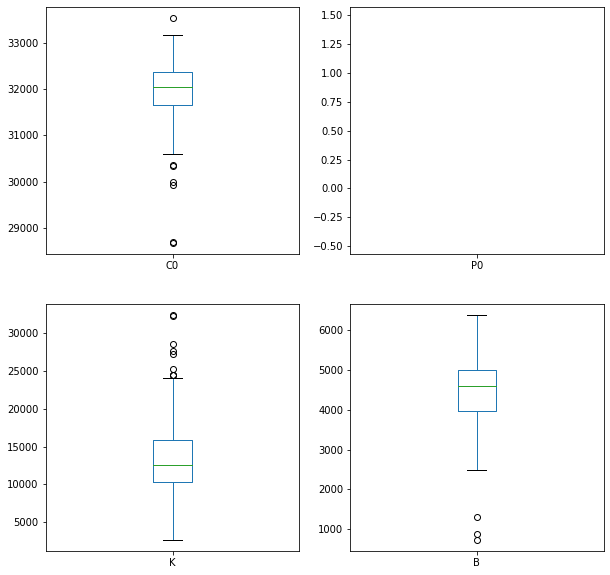

In [19]:
numerical_cols = ['C0', 'P0', 'K', 'B']
df.loc[:, numerical_cols].plot(kind='box', subplots=True, layout=(2, 2), figsize=(10, 10), sharex=False)

Obergrenze berechnen (Nur auf Testdata)

In [20]:
q3 = df.loc[:, numerical_cols].describe().loc['75%']
iqr = q3 - df.loc[:, numerical_cols].describe().loc['25%']
upper_boundary = q3 + 1.5*iqr
upper_boundary

/home/maesi/venv/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike



C0    33456.25
P0         NaN
K     24290.50
B      6562.50
dtype: float64

In [21]:
import pandas_profiling
profile = df.profile_report(style={'full_width':True})
# Save report
# profile.to_file(output_file="sgv-profile.html")
profile